In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

os.getcwd()

'C:\\ProjetosDataScience\\Estudos DOLFUT\\4 - Analises'

In [2]:
file_path = 'C:\\ProjetosDataScience\\Estudos DOLFUT\\2 - Dados Preparados\estudo-fluxo-osc.csv'
df = pd.read_csv(file_path, sep=';')

dolfut_osc = df.drop('perna_fut', axis=1).copy()
dolfut_class = df.drop('osc_fut', axis=1).copy()


In [3]:
dolfut_class.head()

,vol,compra,venda,saldo,osc_abe,osc_fec,osc_aju,osc_vwpm,osc_vwps,osc_vwpd,tempo,perna_fut
0,24875,11240,13635,-2395,-0.002302,-0.001229,-0.000308,-0.000557,0.003254,-0.001622,0.036806,ALTA
1,29080,14305,14775,-470,0.000000,0.001076,0.001999,0.001747,0.005376,0.000946,0.023611,BAIXA
2,171225,85320,85905,-585,-0.002302,-0.001229,-0.000308,-0.000600,0.001973,-0.001846,0.158333,ALTA
3,99785,50640,49145,1495,0.002302,0.003380,0.004306,0.004004,0.006139,0.003094,0.156250,ALTA
4,22475,11850,10625,1225,0.004594,0.004594,0.001680,0.002476,0.010574,0.002476,0.013194,BAIXA


In [6]:
dolfut_class.perna_fut = dolfut_class.perna_fut.apply(lambda x: 1 if x == 'ALTA' else 0)
dolfut_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5102 entries, 0 to 5101
Data columns (total 12 columns):
vol          5102 non-null int64
compra       5102 non-null int64
venda        5102 non-null int64
saldo        5102 non-null int64
osc_abe      5102 non-null float64
osc_fec      5102 non-null float64
osc_aju      5102 non-null float64
osc_vwpm     5102 non-null float64
osc_vwps     5102 non-null float64
osc_vwpd     5102 non-null float64
tempo        5102 non-null float64
perna_fut    5102 non-null int64
dtypes: float64(7), int64(5)
memory usage: 478.4 KB


In [7]:
dolfut_class.describe()

,vol,compra,venda,saldo,osc_abe,osc_fec,osc_aju,osc_vwpm,osc_vwps,osc_vwpd,tempo,perna_fut
count,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000
mean,29698.510388,14844.852999,14853.657389,-8.804390,0.000637,0.000489,0.000250,0.003965,0.001304,0.000137,0.036212,0.498040
std,33975.798801,17163.259122,16963.617260,3213.820831,0.007571,0.008400,0.005530,0.018398,0.008546,0.004370,0.046688,0.500045
min,5.000000,0.000000,0.000000,-20825.000000,-0.038911,-0.051823,-0.030811,-0.051952,-0.035048,-0.022621,-0.013194,0.000000
25%,8113.750000,3981.250000,4045.000000,-1340.000000,-0.003757,-0.004228,-0.002530,-0.007091,-0.003568,-0.002336,0.007639,0.000000
50%,18535.000000,9207.500000,9215.000000,-30.000000,0.000000,0.000659,0.000121,0.003098,0.001125,0.000201,0.019444,0.000000
75%,39286.250000,19383.750000,19718.750000,1190.000000,0.004584,0.005355,0.002738,0.014804,0.005910,0.002626,0.046528,1.000000
max,423210.000000,216105.000000,207105.000000,27275.000000,0.037646,0.030469,0.040264,0.068532,0.038510,0.022977,0.384722,1.000000


In [8]:
dolfut_class.perna_fut.value_counts()

0    2561
1    2541
Name: perna_fut, dtype: int64

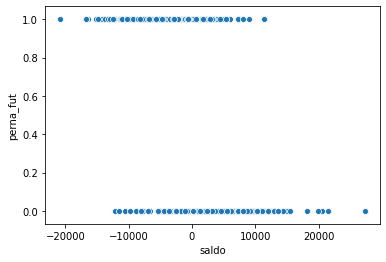

In [9]:
sns.scatterplot('saldo', 'perna_fut', data=dolfut_class)

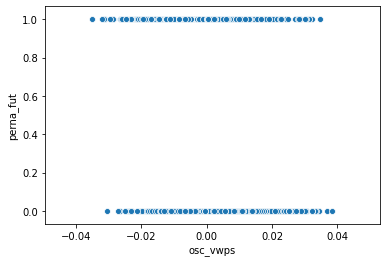

In [13]:
sns.scatterplot('osc_vwps', 'perna_fut', data=dolfut_class)

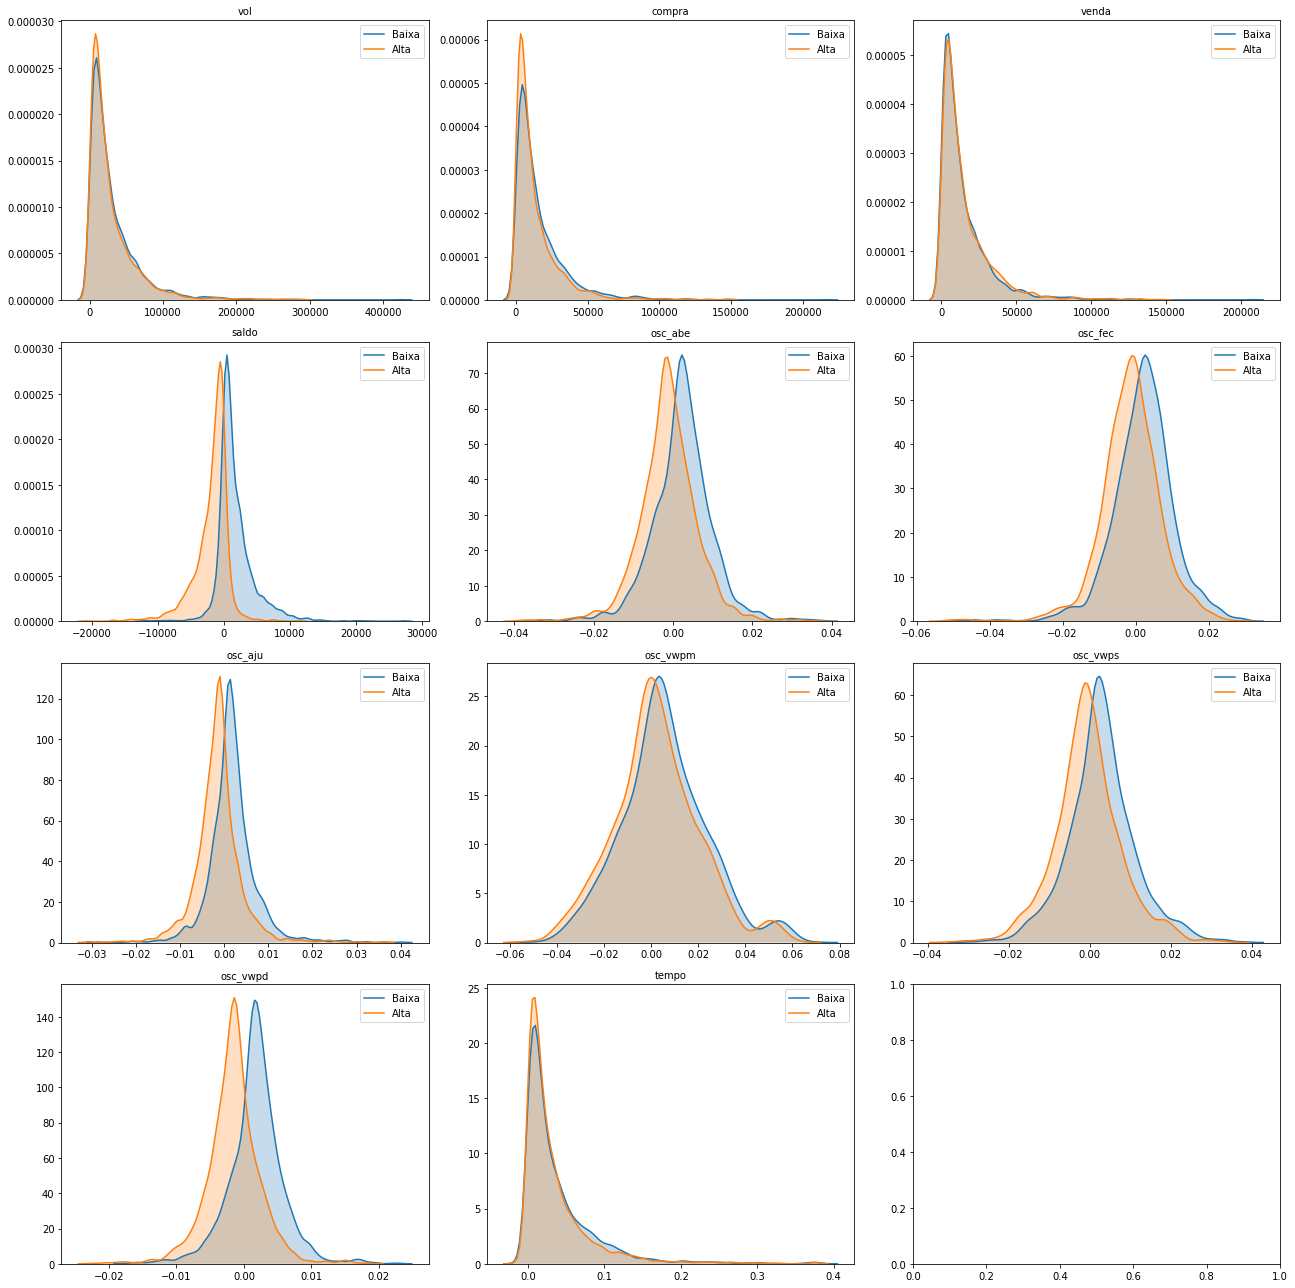

In [14]:
column_names = dolfut_class.drop('perna_fut', axis=1).columns


num_plots = len(column_names)


df_0 = dolfut_class[dolfut_class.perna_fut==0]
df_1 = dolfut_class[dolfut_class.perna_fut==1]

# criando objeto gráfico
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

# criando estrutura de repetição para automatizar a plotagem dos gráficos
idx = 0

for col in column_names:
    idx += 1
    plt.subplot(4,3, idx)
    sns.kdeplot(df_0[col], label = 'Baixa', shade=True)
    sns.kdeplot(df_1[col], label = 'Alta', shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

In [15]:
# normalizar os valores que estão em diferentes ordens de grandeza
scaled_df = dolfut_class.copy()

num_cols = scaled_df.drop('perna_fut', axis=1).columns

scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)
scaled_df.describe()

,vol,compra,venda,saldo,osc_abe,osc_fec,osc_aju,osc_vwpm,osc_vwps,osc_vwpd,tempo,perna_fut
count,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5.102000e+03,5102.000000
mean,-1.060174e-16,-5.736080e-17,2.107291e-16,-3.046476e-18,-2.437181e-18,-3.925602e-17,-1.716907e-17,1.253407e-17,5.157249e-18,-8.007881e-18,-4.584512e-16,0.498040
std,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,0.500045
min,-8.740463e-01,-8.650052e-01,-8.757043e-01,-6.477721e+00,-5.224236e+00,-6.228544e+00,-5.617476e+00,-3.039628e+00,-4.254137e+00,-5.208578e+00,-1.058335e+00,0.000000
25%,-6.353604e-01,-6.330189e-01,-6.372295e-01,-4.142503e-01,-5.805123e-01,-5.616131e-01,-5.028334e-01,-6.009956e-01,-5.701351e-01,-5.660335e-01,-6.120663e-01,0.000000
50%,-3.286046e-01,-3.284869e-01,-3.324297e-01,-6.595790e-03,-8.421201e-02,2.019225e-02,-2.341011e-02,-4.712556e-02,-2.089553e-02,1.463568e-02,-3.591809e-01,0.000000
75%,2.822209e-01,2.644802e-01,2.868238e-01,3.730519e-01,5.212820e-01,5.793004e-01,4.499465e-01,5.892084e-01,5.390892e-01,5.696352e-01,2.209678e-01,1.000000
max,1.158325e+01,1.172737e+01,1.133427e+01,8.490355e+00,4.888825e+00,3.569581e+00,7.236560e+00,3.509832e+00,4.354100e+00,5.227236e+00,7.465389e+00,1.000000


In [17]:
# separar os dados em dados de treino e teste
# separar variáveis alvo e explanatórias
X = scaled_df.drop('perna_fut', axis=1)
y = scaled_df['perna_fut']

# dividir o conjunto entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.25, random_state=220)

0    1920
1    1906
Name: perna_fut, dtype: int64


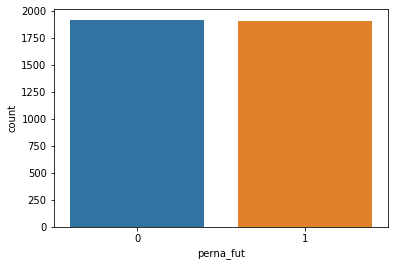

In [20]:
# verificar balanceamento dos dados
print(pd.Series(y_train).value_counts())

sns.countplot(y_train);

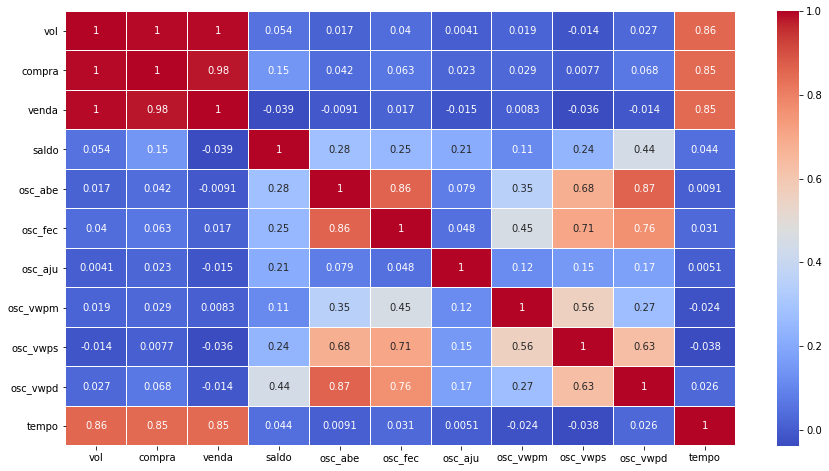

In [21]:
# criar matriz de correlação
corr = pd.DataFrame(X_train).corr()

# plotar matriz de correlação
fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(corr, xticklabels=corr.columns, annot=True, yticklabels=corr.columns, linewidths=0.1, cmap='coolwarm', ax=ax);

In [22]:
parametros = {'learning_rate':[0.01,0.1], 'n_estimators':[100,250,500,750,1000],
                         'max_depth':[1,3], 'subsample':[0.1,1],
                         'colsample_bytree':[0.1,0.5], 'gamma':[0,1],
                         'random_state':[40,70,220]}
xgb = XGBClassifier()
grid = GridSearchCV(xgb, parametros)

In [26]:
# instanciar e treinar o modelo XGB para os dados balanceados
XGB_model = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=1, subsample=0.1,
                         colsample_bytree=0.5, gamma=0,
                         random_state=220)

# fittar o modelo aos dados
XGB_model.fit(X_train, y_train)

# predizer conforme treinamento
y_xgb = XGB_model.predict(X_test)

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       641
           1       0.85      0.85      0.85       635

    accuracy                           0.85      1276
   macro avg       0.85      0.85      0.85      1276
weighted avg       0.85      0.85      0.85      1276

Acurácia: 0.85

AUC: 0.85

0    641
1    635
Name: perna_fut, dtype: int64 



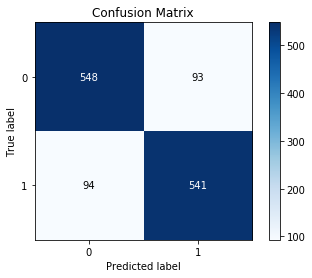

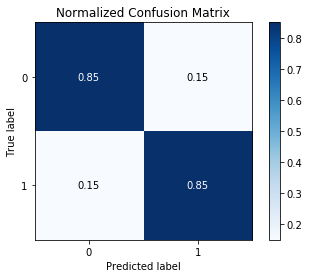

In [27]:
# plotar a matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_xgb, normalize=False)
skplt.metrics.plot_confusion_matrix(y_test, y_xgb, normalize=True)

# imprimir o relatório de classificação
print('Relatório de Classificação: \n', classification_report(y_test, y_xgb, digits=2))

# imprimir acurácia
print('Acurácia: {:.2}\n'.format(accuracy_score(y_test, y_xgb)))

# imprimir área sob curva
print('AUC: {:.2}\n'.format(roc_auc_score(y_test, y_xgb)))

# imprimir total de ativos e inativos
print(y_test.value_counts(),'\n')